# 第2章 機械学習実践のための基礎技術

In [1]:
from sklearn.linear_model import LogisticRegression

from obp.dataset import (
    SyntheticBanditDataset,
    logistic_reward_function,
    linear_behavior_policy
)
from obp.policy import IPWLearner, Random
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DoublyRobust as DR
)

In [2]:
dataset = SyntheticBanditDataset(
    n_actions=3,
    dim_context=3,
    reward_function=logistic_reward_function,
    behavior_policy_function=linear_behavior_policy,
    random_state=42
)

training_data = dataset.obtain_batch_bandit_feedback(n_rounds=10_000)
validation_data = dataset.obtain_batch_bandit_feedback(n_rounds=10_000)

In [3]:
training_data

{'n_rounds': 10000,
 'n_actions': 3,
 'context': array([[ 0.49671415, -0.1382643 ,  0.64768854],
        [ 1.52302986, -0.23415337, -0.23413696],
        [ 1.57921282,  0.76743473, -0.46947439],
        ...,
        [ 1.82488915,  0.87670683, -1.23200845],
        [-1.26120826, -0.57728785,  1.44460398],
        [-0.50136732, -1.89235682, -0.22888421]]),
 'action_context': array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]),
 'action': array([0, 2, 2, ..., 2, 0, 0], dtype=int64),
 'position': None,
 'reward': array([0, 0, 1, ..., 1, 1, 0]),
 'expected_reward': array([[0.77500062, 0.59806539, 0.78045757],
        [0.70775563, 0.70251498, 0.67146348],
        [0.84363276, 0.73350762, 0.8090983 ],
        ...,
        [0.78972055, 0.74224424, 0.74926757],
        [0.67793653, 0.35453455, 0.77988468],
        [0.19056515, 0.35194266, 0.30239658]]),
 'pscore': array([0.4377016 , 0.28114581, 0.28114581, ..., 0.28114581, 0.4377016 ,
        0.4377016 ])}

In [4]:
validation_data

{'n_rounds': 10000,
 'n_actions': 3,
 'context': array([[ 6.98604849e-01,  2.65029116e-01, -1.94166997e+00],
        [-4.03197718e-01, -1.36163316e-01,  4.84918054e-02],
        [-1.32058279e+00, -7.63015504e-01, -6.22943739e-01],
        ...,
        [-1.64031354e-03, -1.37057354e+00,  1.84480587e+00],
        [ 3.69396629e-01,  1.85571235e+00, -3.49227013e-01],
        [ 4.71847086e-01,  9.92766003e-01,  3.29820699e-01]]),
 'action_context': array([[1, 0, 0],
        [0, 1, 0],
        [0, 0, 1]]),
 'action': array([0, 2, 2, ..., 2, 0, 0], dtype=int64),
 'position': None,
 'reward': array([0, 1, 0, ..., 1, 1, 1]),
 'expected_reward': array([[0.45026611, 0.54420176, 0.51821251],
        [0.61374983, 0.44164889, 0.70217956],
        [0.2752914 , 0.27166052, 0.46451948],
        ...,
        [0.68022828, 0.52336973, 0.70921962],
        [0.91333453, 0.61698608, 0.91597032],
        [0.88795911, 0.62466581, 0.88650086]]),
 'pscore': array([0.4377016 , 0.28114581, 0.28114581, ..., 0.28114

In [5]:
ipw_learner = IPWLearner(
    n_actions=dataset.n_actions,
    base_classifier=LogisticRegression(C=100, random_state=42)
)

ipw_learner.fit(
    context=training_data["context"],
    action=training_data["action"],
    reward=training_data["reward"],
    pscore=training_data["pscore"]
)

random = Random(n_actions=dataset.n_actions)

In [6]:
action_choice_by_ipw_learner = ipw_learner.predict(
    context=validation_data["context"]
)

action_choice_by_random = random.compute_batch_action_dist(
    n_rounds=validation_data["n_rounds"]
)

In [7]:
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    base_model=LogisticRegression(C=100, random_state=42)
)

estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=validation_data["context"],
    action=validation_data["action"],
    reward=validation_data["reward"],
    random_state=42
)

In [8]:
ope = OffPolicyEvaluation(
    bandit_feedback=validation_data,
    ope_estimators=[IPS(), DR()]
)

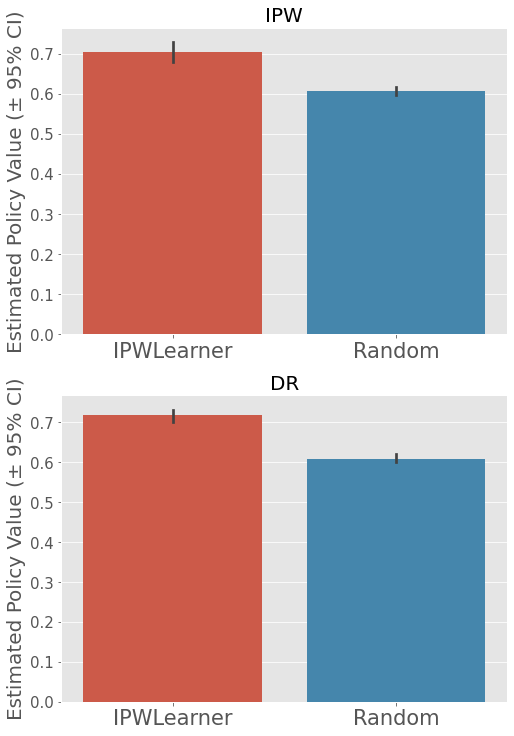

In [9]:
ope.visualize_off_policy_estimates_of_multiple_policies(
    policy_name_list=["IPWLearner", "Random"],
    action_dist_list=[
        action_choice_by_ipw_learner,
        action_choice_by_random
    ],
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    random_state=42
)

In [10]:
performance_of_ipw_learner = dataset.calc_ground_truth_policy_value(
    expected_reward=validation_data["expected_reward"],
    action_dist=action_choice_by_ipw_learner
)
performance_of_random = dataset.calc_ground_truth_policy_value(
    expected_reward=validation_data["expected_reward"],
    action_dist=action_choice_by_random
)

print(f"IPWLearner + Logistic: {performance_of_ipw_learner:.3f}")
print(f"Random               : {performance_of_random:.3f}")

IPWLearner + Logistic: 0.711
Random               : 0.611


# Open Bandit Datasetを用いた分析

In [11]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

from obp.dataset import OpenBanditDataset
from obp.policy import IPWLearner
from obp.ope import (
    OffPolicyEvaluation,
    RegressionModel,
    InverseProbabilityWeighting as IPS,
    DoublyRobust as DR
)

In [12]:
dataset = OpenBanditDataset(
    behavior_policy="bts",
    campaign="men",
    data_path=None
)

training_data, validation_data = dataset.obtain_batch_bandit_feedback(
    test_size=0.3,
    is_timeseries_split=True
)

INFO:obp.dataset.real:When `data_path` is not given, this class downloads the example small-sized version of the Open Bandit Dataset.
c:\Users\sozulab\Desktop\policy_design\.venv\lib\site-packages\obp\dataset\real.py:203: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  item_feature_cat = self.item_context.drop("item_feature_0", 1).apply(
c:\Users\sozulab\Desktop\policy_design\.venv\lib\site-packages\obp\dataset\real.py:206: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  self.action_context = pd.concat([item_feature_cat, item_feature_0], 1).values


In [13]:
training_data

{'n_rounds': 7000,
 'n_actions': 34,
 'action': array([ 2,  9, 13, ..., 23,  0, 13], dtype=int64),
 'position': array([1, 2, 2, ..., 2, 0, 2]),
 'reward': array([0, 0, 0, ..., 0, 0, 0], dtype=int64),
 'pscore': array([0.045525, 0.059345, 0.173365, ..., 0.256435, 0.13785 , 0.23507 ]),
 'context': array([[0, 1, 1, ..., 1, 0, 0],
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 1, 0, 0],
        ...,
        [0, 1, 0, ..., 0, 0, 0],
        [0, 1, 0, ..., 0, 0, 1],
        [0, 1, 0, ..., 0, 0, 0]], dtype=uint8),
 'action_context': array([[ 0.        ,  4.        ,  2.        ,  3.        , -0.67718311],
        [ 1.        ,  3.        ,  2.        ,  3.        , -0.72029964],
        [ 2.        ,  3.        , 13.        ,  2.        ,  0.74566231],
        [ 3.        ,  0.        , 15.        ,  1.        , -0.69874138],
        [ 4.        ,  2.        , 14.        ,  2.        ,  1.65110939],
        [ 5.        ,  2.        , 12.        ,  3.        ,  0.14203092],
        [ 

In [14]:
new_decision_making_model = IPWLearner(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    base_classifier=RandomForestClassifier(
        n_estimators=300, max_depth=10, min_samples_leaf=5, random_state=42
    )
)

new_decision_making_model.fit(
    context=training_data["context"],
    action=training_data["action"],
    reward=training_data["reward"],
    position=training_data["position"],
    pscore=training_data["pscore"]
)

action_dist = new_decision_making_model.predict(
    context=validation_data["context"]
)

In [15]:
regression_model = RegressionModel(
    n_actions=dataset.n_actions,
    len_list=dataset.len_list,
    base_model=LogisticRegression(C=100, random_state=42)
)

estimated_rewards_by_reg_model = regression_model.fit_predict(
    context=validation_data["context"],
    action=validation_data["action"],
    reward=validation_data["reward"],
    position=validation_data["position"],
    random_state=42
)

In [16]:
ope = OffPolicyEvaluation(
    bandit_feedback=validation_data,
    ope_estimators=[IPS(), DR()]
)

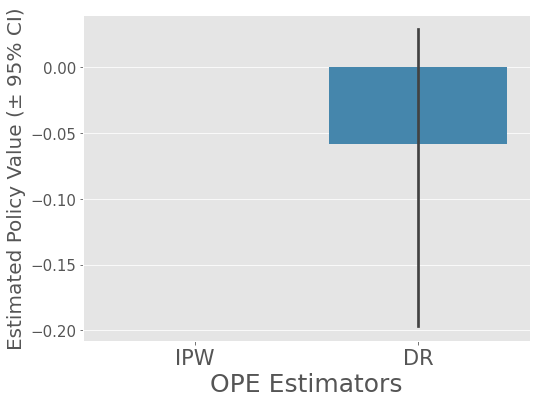

In [17]:
ope.visualize_off_policy_estimates(
    action_dist=action_dist,
    estimated_rewards_by_reg_model=estimated_rewards_by_reg_model,
    is_relative=True
)